In [1]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import load
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from numpy import linalg as la
from matplotlib import pyplot
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# face detection for the 5 Celebrity Faces Dataset
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
 
# load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('data/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
# load the face dataset
data = load('datasets/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

In [2]:
# load the facenet model
model = load_model('keras-facenet/model/facenet_keras.h5')
print('Loaded Model')

Instructions for updating:
Colocations handled automatically by placer.
Loaded Model


C:\Users\lenovo\Anaconda3\envs\PythonCPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('datasets/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('keras-facenet/model/facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

In [ ]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

In [4]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]

data = np.load("custom_lfw_jostel_4.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

path_to_model = "../model/facenet_keras.h5"
model = load_model(path_to_model)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [6]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("custom_lfw_jostel_4_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

In [7]:
# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1 

# new_emb = [0.42, -0.11, ..., 0], [1.22, -2.11, ..., 24] 
# OBS: - the last number in the array (new_emb) is the index of the img in their raw dataset (the img dataset)


#print(raw_trainX[0])
#print(trainX2[0][-1])
#print(raw_trainX[int(trainX2[0][-1])])
#plt.imshow(raw_trainX[int(trainX2[0][-1])])

In [9]:
# Verifying identity

# 1) Pair formattion

how_many = len(trainX2) # how_many = 93

# Formation of pairs (everyone with everyone)

pairs = list() 
# pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

for i in range(how_many):
    for j in range(i+1, how_many):
        pair = list()
        #print("(" + str(i) + "," + str(j) + ")")
        img_i = trainX2[i][0:-1]
        label_i = trainX2[i][-1]
        img_j = trainX2[j][0:-1]
        label_j = trainX2[j][-1]
        pair.append(img_i)
        pair.append(img_j)
        pair.append(label_i)
        pair.append(label_j)
        pairs.append(pair)
        
#print(img_i.shape)
#print(img_j.shape)
#print(label_i)
#print(label_j)
#print(len(pairs)) - len(pairs) = 4278

# 2) Pair comparison

#threshold = [0.2, 0.5, 0.9]
threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
Psame = list()
Pdiff = list()
for t in range(len(threshold)):
    #print("Threshold: " + str(threshold[t]))
    for pair in pairs:
        norm = np.linalg.norm(pair[0] - pair[1])**2
        comparison = [pair[0], pair[1], pair[2], pair[3], norm]
        if norm < threshold[t]:
            Psame.append(comparison)
        else:
            Pdiff.append(comparison)
    #print(pair[0])
       
# comparison = [img_i, img_j, label_i, label_j, norm]
        
#print(pair[0])
#print(pair[1])
#print(pair[2])
#print(pair[3])
print("Pairs: " + str(len(pairs)))
print("Psame: " + str(len(Psame)))
print("Pdiff: " + str(len(Pdiff)))
#print(Psame[0])
#plt.imshow(raw_trainX[int(pair[2])])
#plt.show()
#plt.imshow(raw_trainX[int(pair[3])])
#plt.show()

# 3) VAL and FAR rates

VAL_list = []
FAR_list = []
for t in range(len(threshold)):
    TA = [] 
    ta_d = []
    FA = []
    fa_d = []
    #VAL = np.zeros(len(threshold), dtype=float)
    #FAR = np.zeros(len(threshold))
    for pair in Psame:
        if pair[-1] <= threshold[t]:
            TA.append(pair)
    ta_counter = len(TA)
    print("TA:" + str(ta_counter))
    #ta_d.append(ta_counter) 
    for pair in Pdiff:
        if pair[-1] <= threshold[t]:
            FA.append(pair)
    fa_counter = len(FA)
    fa_d.append("FA:" + str(fa_counter))
    val = ta_counter/len(Psame)
    #v = np.round(val, 4)
    print("VAL:" + str(val))
    VAL_list.append(val)
    #VAL[t] += np.asarray(VAL_list)
    #VAL_round[t] += VAL_round[t] + np.round(VAL[t], 3)
    #VAL[t] = np.around(VAL[t], decimals=4)
    #print(VAL)
    far = fa_counter/len(Pdiff)
    print("FAR:" + str(far))
    FAR_list.append(far)
    #FAR[t] += np.asarray(FAR_list)
#VAL = np.asarray(VAL_list)
#reverse_list_val = np.sorted()
#FAR = np.asarray(FAR_list)   
#for t in range(len(threshold)):
    #VAL = []
    #TA_count = TA.
    #v = len(TA)/len(Psame)
    #FAR = len(FA)/len(Pdiff)
    #print("TA: " + str(len(TA)))
    #print("FA: " + str(len(FA)))
    #print("VAL: " + str(VAL))
    #print("FAR: " + str(FAR))
#ta_array = np.array(TA)
#print(np.abs(ta_array)) 
#print(len(ta_array))

#ta = np.array(TA)
#ps = np.array(Psame)
#fa = np.array(FA)
#pd = np.array(Pdiff)
#val = abs(ta)/abs(ps)
#far = abs(fa)/abs(pd)
#print(VAL[0])
#print(VAL[1])
#print(VAL[2])
###print(FAR)

Pairs: 176121
Psame: 11682
Pdiff: 1573407
TA:9
VAL:0.0007704160246533128
FAR:0.0
TA:753
VAL:0.06445814072932717
FAR:5.9107401962747086e-05
TA:2601
VAL:0.2226502311248074
FAR:0.0003946849098802789
TA:5217
VAL:0.4465844889573703
FAR:0.0012260019181305282
TA:7627
VAL:0.6528847800034241
FAR:0.0024513682727990913
TA:9487
VAL:0.8121040917651087
FAR:0.003929053321867769
TA:10585
VAL:0.9060948467728128
FAR:0.005324750684342958
TA:11301
VAL:0.9673857216230097
FAR:0.0069174727200273034
TA:11682
VAL:1.0
FAR:0.008854670152096691


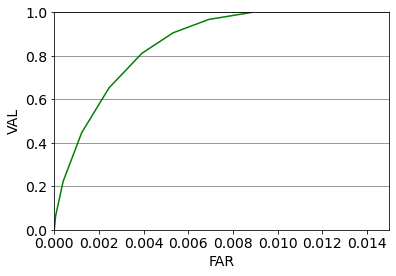

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)

plt.show()

In [28]:
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold:" + str(threshold[t]) + "es" + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold:" + str(threshold[t]) + "es" + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return

# Metric Plot

Pairs: 176121
Psame: 11682
Pdiff: 1573407
VAL para threshold:0.1es0.0007704160246533128
FAR para threshold:0.1es0.0
VAL para threshold:0.2es0.06445814072932717
FAR para threshold:0.2es5.9107401962747086e-05
VAL para threshold:0.30000000000000004es0.2226502311248074
FAR para threshold:0.30000000000000004es0.0003946849098802789
VAL para threshold:0.4es0.4465844889573703
FAR para threshold:0.4es0.0012260019181305282
VAL para threshold:0.5es0.6528847800034241
FAR para threshold:0.5es0.0024513682727990913
VAL para threshold:0.6es0.8121040917651087
FAR para threshold:0.6es0.003929053321867769
VAL para threshold:0.7000000000000001es0.9060948467728128
FAR para threshold:0.7000000000000001es0.005324750684342958
VAL para threshold:0.8es0.9673857216230097
FAR para threshold:0.8es0.0069174727200273034
VAL para threshold:0.9es1.0
FAR para threshold:0.9es0.008854670152096691
---------------------
[0.0, 5.9107401962747086e-05, 0.0003946849098802789, 0.0012260019181305282, 0.0024513682727990913, 0.003

/home/jose/Documents/IPD441/Proyecto/rebuild/faces/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jose/Documents/IPD441/Proyecto/rebuild/faces/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

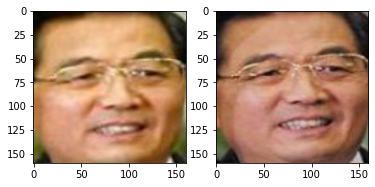

<Figure size 432x288 with 0 Axes>

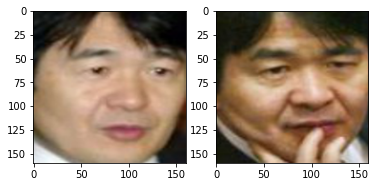

<Figure size 432x288 with 0 Axes>

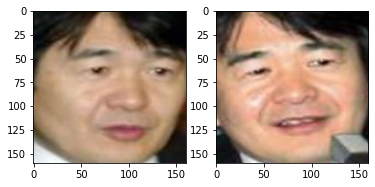

<Figure size 432x288 with 0 Axes>

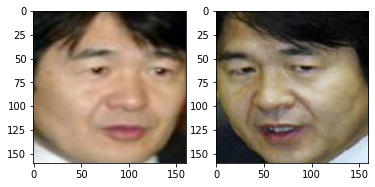

<Figure size 432x288 with 0 Axes>

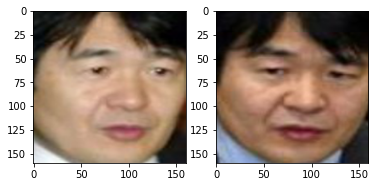

<Figure size 432x288 with 0 Axes>

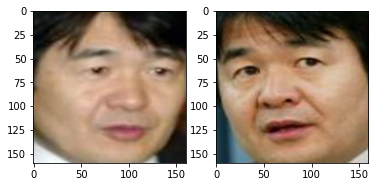

<Figure size 432x288 with 0 Axes>

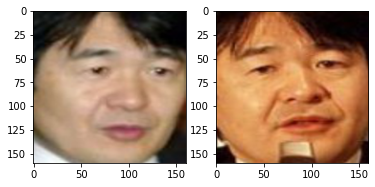

<Figure size 432x288 with 0 Axes>

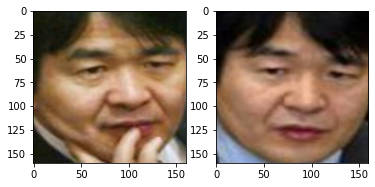

<Figure size 432x288 with 0 Axes>

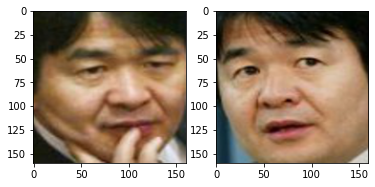

<Figure size 432x288 with 0 Axes>

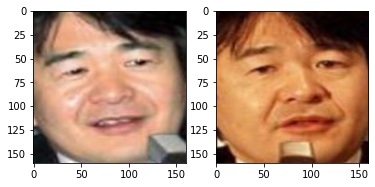

<Figure size 432x288 with 0 Axes>

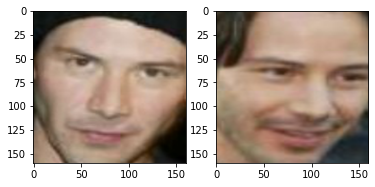

<Figure size 432x288 with 0 Axes>

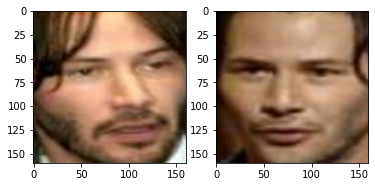

<Figure size 432x288 with 0 Axes>

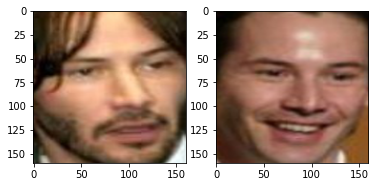

<Figure size 432x288 with 0 Axes>

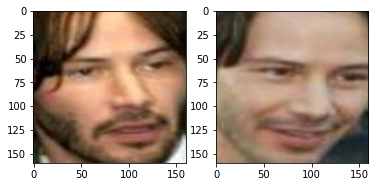

<Figure size 432x288 with 0 Axes>

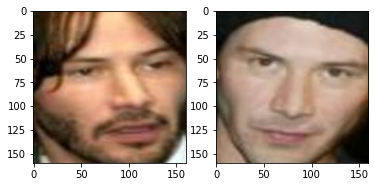

<Figure size 432x288 with 0 Axes>

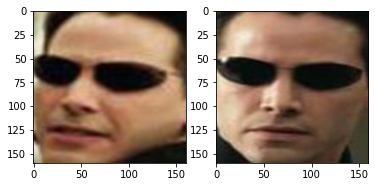

<Figure size 432x288 with 0 Axes>

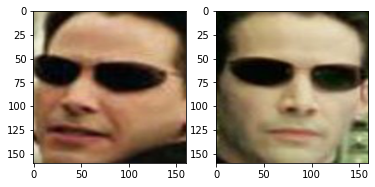

<Figure size 432x288 with 0 Axes>

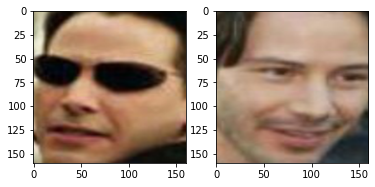

<Figure size 432x288 with 0 Axes>

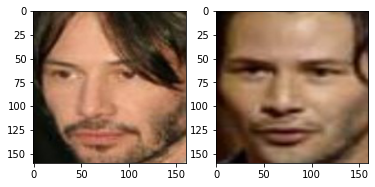

<Figure size 432x288 with 0 Axes>

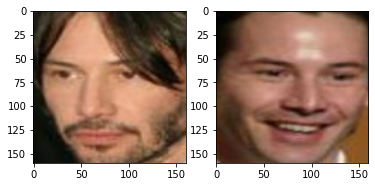

In [29]:
first_iteration = metric_obtention(trainX2)
#first_iteration = metric_obtention(trainX2, 0.7)
#second_iteration = metric_obtention(trainX2, 0.6)
#thirditeration = metric_obtention(trainX2, 0.5)
print("---------------------")
#plt.figure()
#f, axarr = plt.subplots(1,2)
#axarr[0].imshow(raw_trainX[int(first_iteration[1][50][2])])
#axarr[1].imshow(raw_trainX[int(first_iteration[1][50][3])])

print(first_iteration[-1])
print(first_iteration[-2])
    
face_pairs_plot(first_iteration, raw_trainX, 10)

print("EXAMPLE PLOT")

for i in range(10):
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(raw_trainX[int(first_iteration[1][-(i+10)][2])])
    axarr[1].imshow(raw_trainX[int(first_iteration[1][-(i+10)][3])])
    
    
#start = 1 # 0.1
#end = 15  # 1.5
#steps = 1 # 0.1
#from iter in range(start, end,)
#for i in range(start, end, steps):
    #iteration = metric_obtention(trainX2, 0.1*i)
    #print(0.1*i)

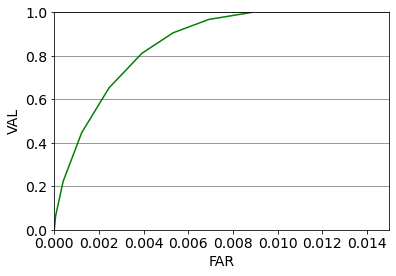

In [24]:
x = first_iteration[-1]
y = first_iteration[-2]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)
#ax.invert_xaxis()
#ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
ax.plot(x, y, 'g-', linewidth = 1.5)


plt.show()